In [1]:
import pandas as pd
import random
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas_ta as ta

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
df = pd.read_csv('nifty.csv', index_col=0, low_memory=False)

In [5]:
df.head()

,Close,High,Low,Open,Volume,date,weekday,month
0,6082.299805,6094.350098,6065.100098,6085.750000,130900,21-01-2013,0,1
1,6048.500000,6101.299805,6040.500000,6080.149902,129000,22-01-2013,1,1
2,6054.299805,6069.799805,6021.149902,6052.850098,137000,23-01-2013,2,1
3,6019.350098,6065.299805,6007.850098,6046.200195,185200,24-01-2013,3,1
4,6074.649902,6080.549805,6014.450195,6024.500000,147600,25-01-2013,4,1


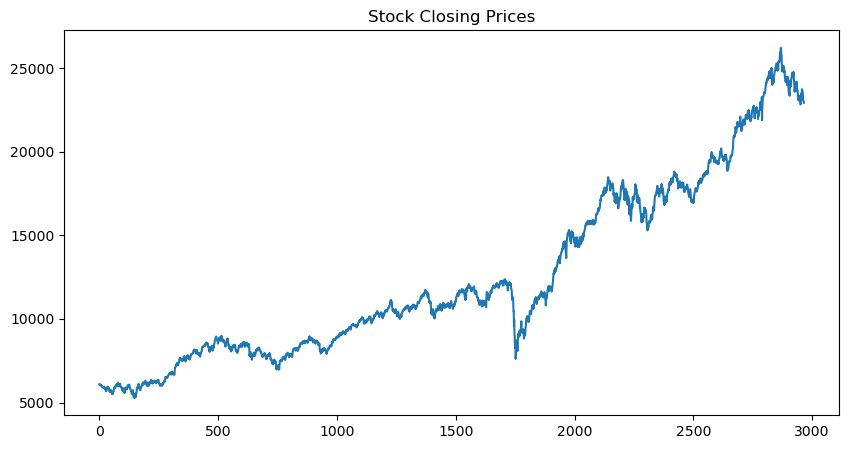

In [6]:
df["Close"].plot(title="Stock Closing Prices", figsize=(10, 5))
plt.show()


In [7]:
# Step 2: Check for Stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print("ADF Test Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] > 0.05:
        print("The series is NOT stationary.")
    else:
        print("The series is stationary.")

check_stationarity(df['Close'])

ADF Test Statistic: 0.24930900742430295
p-value: 0.9748954743557529
The series is NOT stationary.


In [11]:
df.tail()

,Close,High,Low,Open,Volume,date,weekday,month,Close_diff
2961,23381.59961,23568.59961,23316.30078,23543.80078,234200,10-02-2025,0,2,-178.34961
2962,23071.80078,23390.05078,22986.65039,23383.55078,268000,11-02-2025,1,2,-309.79883
2963,23045.25000,23144.69922,22798.34961,23050.80078,279700,12-02-2025,2,2,-26.55078
2964,23031.40039,23235.50000,22992.19922,23055.75000,265700,13-02-2025,3,2,-13.84961
2965,22929.25000,23133.69922,22774.84961,23096.44922,254500,14-02-2025,4,2,-102.15039


In [9]:
# If not stationary, apply differencing
df['Close_diff'] = df['Close'].diff().dropna()
check_stationarity(df['Close_diff'].dropna())


ADF Test Statistic: -22.426123653877397
p-value: 0.0
The series is stationary.


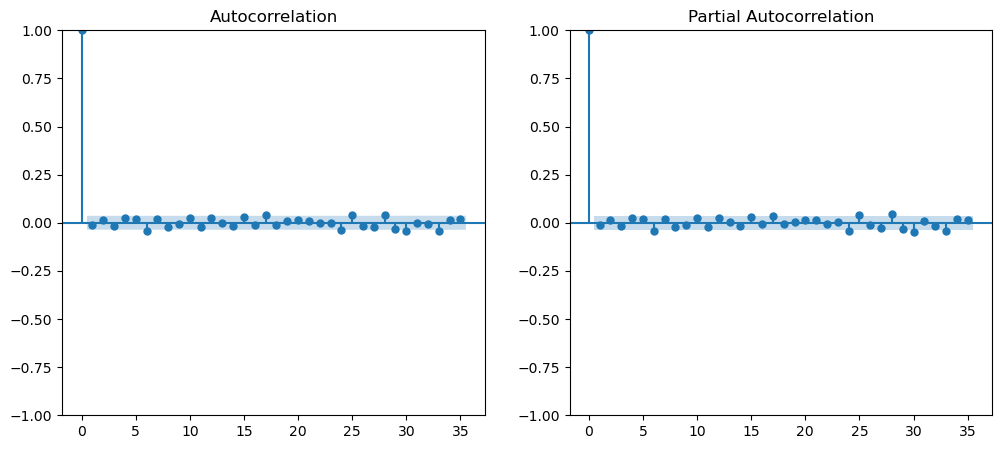

In [12]:
# Step 3: Identify ARIMA Parameters (p, d, q)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df['Close_diff'].dropna(), ax=ax[0])
plot_pacf(df['Close_diff'].dropna(), ax=ax[1])
plt.show()


In [13]:
# Step 4: Fit the ARIMA Model
p, d, q = 4, 1, 2  # Adjust based on ACF/PACF analysis
model = ARIMA(df['Close'][:-20], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())


C:\Users\IIITNAGPUR\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\IIITNAGPUR\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2946
Model:                 ARIMA(4, 1, 2)   Log Likelihood              -18454.266
Date:                Wed, 19 Feb 2025   AIC                          36922.532
Time:                        13:20:29   BIC                          36964.447
Sample:                             0   HQIC                         36937.623
                               - 2946                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0165      0.285      0.058      0.954      -0.542       0.575
ar.L2         -0.4151      0.230     -1.806      0.071      -0.866       0.035
ar.L3         -0.0205      0.012     -1.718      0.0

In [14]:
# Step 5: Make Predictions
forecast_steps = 20  # Predict for 20 days
forecast_index = pd.date_range(start=df.index[-20], periods=forecast_steps, freq='B')
forecast = model_fit.forecast(steps=forecast_steps)

In [15]:
forecast

2946    23209.060802
2947    23212.212479
2948    23216.091906
2949    23210.288008
2950    23208.756753
2951    23211.189999
2952    23212.143541
2953    23210.943374
2954    23210.415188
2955    23210.984575
2956    23211.276849
2957    23211.007091
2958    23210.848031
2959    23210.974663
2960    23211.060267
2961    23211.001350
2962    23210.955741
2963    23210.982864
2964    23211.006954
2965    23210.994620
Name: predicted_mean, dtype: float64

In [16]:
# Step 6: Evaluate Performance
y_true = df['Close'][-forecast_steps:]
y_pred = forecast[:forecast_steps]

In [17]:
y_true

2946    23344.75000
2947    23024.65039
2948    23155.34961
2949    23205.34961
2950    23092.19922
2951    22829.15039
2952    22957.25000
2953    23163.09961
2954    23249.50000
2955    23508.40039
2956    23361.05078
2957    23739.25000
2958    23696.30078
2959    23603.34961
2960    23559.94922
2961    23381.59961
2962    23071.80078
2963    23045.25000
2964    23031.40039
2965    22929.25000
Name: Close, dtype: float64

<Axes: >

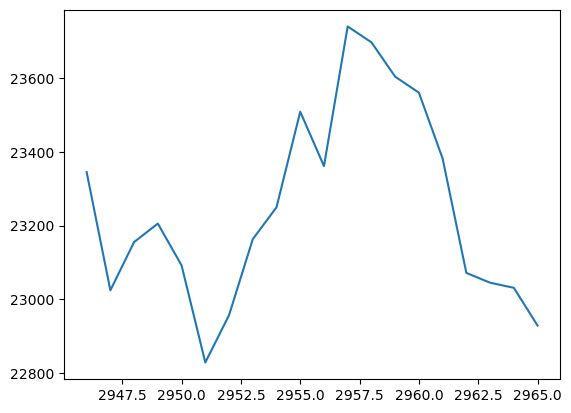

In [18]:
y_true.plot()

<Axes: >

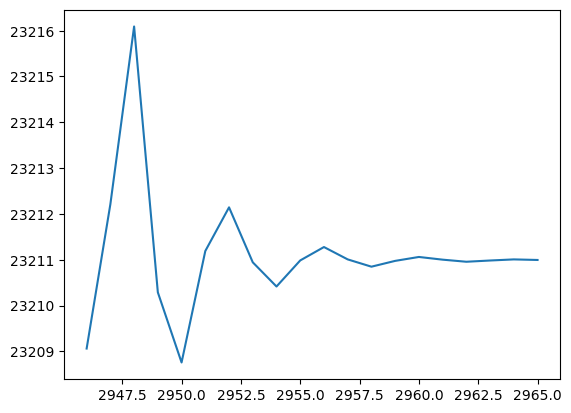

In [19]:
y_pred.plot()

In [20]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 218.41689067457827
RMSE: 262.15273583675355
